In [329]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.inference import DBNInference

from models.model_v0 import DumbDiscretizer, pgmpy_friendly_transformer, CustomDBNInference

# I. General settings

In [572]:
# load data parameters 
countries = ['France', 'Germany', 'United Kingdom', 'Italy', 'Spain', 'Japan', 
             'Sweden', 'Switzerland', 'Belgium', 'Australia', 'Austria', 'China', 
             'Croatia', 'Finland', 'Greece', 'India', 'New Zealand', 
             'Russia']
columns = ['year', 'population', 'gdp', 'energy_per_capita', 'country']

# preprocessing parameters
split_year = 2009  # trainset until split_year
test_country = "United Kingdom"
sliding_window = 2
# define discretization strategy
nb_classes = {  # nb of classes for each variable
    "gdp_stationary": 10,  
    "population_stationary": 10, 
    "energy_per_capita_stationary": 5
}

# model parameters


# II. Load data

### Load raw data 

In [573]:
all_data = pd.read_csv("./data/World Energy Consumption.csv")
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22012 entries, 0 to 22011
Columns: 129 entries, country to wind_share_energy
dtypes: float64(126), int64(1), object(2)
memory usage: 21.7+ MB


### Select columns

In [574]:
data = all_data[columns]
data.describe()

,year,population,gdp,energy_per_capita
count,22012.000000,1.812300e+04,1.111300e+04,10602.000000
mean,1974.213247,1.053096e+08,3.585114e+11,25742.760033
std,35.058653,4.640460e+08,2.411179e+12,36122.506628
min,1900.000000,1.833000e+03,1.642060e+08,0.000000
25%,1946.000000,1.712404e+06,1.365898e+10,3101.076250
50%,1984.000000,6.991543e+06,4.167411e+10,13597.986000
75%,2003.000000,2.557688e+07,1.744295e+11,36847.052500
max,2022.000000,7.975105e+09,1.136302e+14,657539.188000


### Select countries

In [575]:
data = data.loc[data.country.isin(countries)]
data.dropna(inplace=True)  # drop all nan values
data.sample(5)

,year,population,gdp,energy_per_capita,country
4386,2003,1.288873e+09,7.248622e+12,12273.320,China
8086,2018,1.063328e+07,2.500358e+11,30475.123,Greece
7174,1965,4.564582e+06,5.579619e+10,25282.402,Finland
16940,2017,1.454525e+08,3.524075e+12,55974.684,Russia
18738,2001,8.896748e+06,3.083992e+11,77094.320,Sweden


# III. Preprocessing 

### Stationarization 

Fonction permettant de stationariser les time series:

In [576]:
def stationarize(input_df: pd.DataFrame):
    """
    Given data corresponding to only one country, 
    create new columns for time series stationarization.

    :params input_df: pd.DataFrame
        Dataframe of a ocuntry with at least gdp, energy_per_capita and 
        population columns 

    :return pd.DataFrame
    """
    # copy input dataframe 
    df = input_df.copy()

    # stationarisation of gdp 
    df['log_gdp'] = df['gdp'].apply(lambda x: np.log(x))
    df['gdp_order_1'] = df['log_gdp'] - df['log_gdp'].shift()
    df['gdp_stationary'] = df['gdp_order_1'] - df['gdp_order_1'].shift()

    # stationarization of energy consumption per capita
    df['log_energy'] = df['energy_per_capita'].apply(lambda x: np.log(x))
    df['energy_per_capita_order_1'] = df['log_energy'] - df['log_energy'].shift()
    df['energy_per_capita_stationary'] = df['energy_per_capita_order_1'] - df['energy_per_capita_order_1'].shift()
    
    # stationarization of population
    df['log_pop'] = df['population'].apply(lambda x: np.log(x))
    df['population_order_1'] = df['log_pop'] - df['log_pop'].shift()
    df['population_stationary'] = df['population_order_1'] - df['population_order_1'].shift()

    # new create columns 
    new_columns = [
        "gdp_stationary", 
        "energy_per_capita_stationary",
        "population_stationary"
    ]

    # old columns to keep 
    old_cols = ["country", "year"]

    return df[new_columns + old_cols]

In [577]:
# stationarize data 
for i, country in enumerate(countries):
    df_country = stationarize(data[data.country == country])

    if i == 0:
        df_stationary = df_country
    else:
        df_stationary = pd.concat([df_stationary, df_country])

df_stationary.sample(10)

,gdp_stationary,energy_per_capita_stationary,population_stationary,country,year
13391,0.039999,0.031004,-0.002944,New Zealand,1993
9256,-0.013195,-0.017187,-0.000281,India,1990
2368,0.026494,0.005984,-0.000090,Belgium,1982
9267,0.013377,-0.044963,-0.000137,India,2001
18733,-0.022712,-0.039149,-0.000930,Sweden,1996
16909,NaN,NaN,NaN,Russia,1986
16939,0.027268,0.035728,0.000389,Russia,2016
7224,0.009033,0.033695,-0.000846,Finland,2015
20578,0.005874,-0.018774,-0.000515,United Kingdom,2013
18866,0.009426,0.081488,-0.000135,Switzerland,2006


Nous devons analyser pourquoi des NaN se glissent dans le dataframe à cette étape (j'y reviens plus tard)

In [578]:
df_stationary[df_stationary.isna()].shape[0]

927

### Train-Test split 

In [579]:
df_test = df_stationary.loc[(df_stationary.country == test_country)
                            & (df_stationary.year> split_year)]
df_train = df_stationary[~df_stationary.index.isin(df_test.index)]

print(f"Train size: {df_train.shape[0]}")
print(f"Test size: {df_test.shape[0]}")

Train size: 918
Test size: 9


In [580]:
df_train.dropna(inplace=True)

C:\Users\elkan\AppData\Local\Temp\ipykernel_11428\370300940.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.dropna(inplace=True)


### Discretization 

In [581]:
print(f"{df_train[~df_train.isna()].shape[0]} rows without NaN")

882 rows without NaN


In [582]:
# define discretizer object 
discretizer = DumbDiscretizer(df_train, nb_classes=nb_classes)

# indexed dataframe 
df_index = discretizer.df

# print nb of NaN (must be investigated later) and dorp them
print(f"Nb of rows continaing NaN values: {df_index.isna().shape[1]}")
df_index.dropna(inplace=True)
df_index.sample(5)

Nb of rows continaing NaN values: 5


,gdp_stationary,energy_per_capita_stationary,population_stationary,country,year
7302,4,2,4,France,1970
18373,5,2,4,Spain,1982
8042,2,0,5,Greece,1974
7205,4,4,4,Finland,1996
9976,5,2,5,Italy,1972


### PGMPY friendly preprocessing

In [583]:
for i, country in enumerate(countries):

    # select country and relevant columns
    df_country = df_index[df_index.country == country]
    df_country = df_country.drop(["country", "year"], axis=1)
    
    print(f"Country: {country}", df_country.shape)

    # transform in a pgmpy friendly dataframe
    df_pgmpy_country = pgmpy_friendly_transformer(
        df=df_country, 
        sliding_window=sliding_window
    )
    df_pgmpy_country["country"] = country

    if i == 0:
        df_pgmpy = df_pgmpy_country
    else:
        df_pgmpy = pd.concat([df_pgmpy, df_pgmpy_country])

df_pgmpy.reset_index(inplace=True, drop=True)
df_pgmpy.sample(10)

Country: France (52, 3)
Country: Germany (52, 3)
Country: United Kingdom (43, 3)
Country: Italy (52, 3)
Country: Spain (52, 3)
Country: Japan (52, 3)
Country: Sweden (52, 3)
Country: Switzerland (52, 3)
Country: Belgium (52, 3)
Country: Australia (52, 3)
Country: Austria (52, 3)
Country: China (52, 3)
Country: Croatia (27, 3)
Country: Finland (52, 3)
Country: Greece (52, 3)
Country: India (52, 3)
Country: New Zealand (52, 3)
Country: Russia (32, 3)


,"(gdp_stationary, 0)","(energy_per_capita_stationary, 0)","(population_stationary, 0)","(gdp_stationary, 1)","(energy_per_capita_stationary, 1)","(population_stationary, 1)",country
29,4,3,5,5,2,5,France
493,7,3,4,3,2,5,Austria
128,5,2,5,5,3,5,United Kingdom
16,4,3,4,5,3,4,France
813,3,2,4,5,2,4,Russia
743,5,3,4,4,2,4,India
519,4,2,5,5,2,4,Austria
800,5,2,4,4,2,4,Russia
621,5,3,4,4,2,4,Finland
350,5,3,4,4,2,4,Switzerland


In [584]:
df_pgmpy[df_pgmpy.country == "France"].tail()

,"(gdp_stationary, 0)","(energy_per_capita_stationary, 0)","(population_stationary, 0)","(gdp_stationary, 1)","(energy_per_capita_stationary, 1)","(population_stationary, 1)",country
44,5,2,4,4,3,4,France
45,4,3,4,5,3,4,France
46,5,3,4,4,2,4,France
47,4,2,4,5,3,4,France
48,5,3,4,4,2,4,France


# Model 

### Training 

In [585]:
# build model 
dbn = DBN([
    (("gdp_stationary", 0), ("energy_per_capita_stationary", 0)), 
    (("population_stationary", 0), ("energy_per_capita_stationary", 0)), 
    (("population_stationary", 0), ("population_stationary", 1)), 
    (("gdp_stationary", 0), ("gdp_stationary", 1))
])

In [586]:
dbn.fit(df_pgmpy.drop("country", axis=1))

# Inferences 

### Scenarios

In [587]:
length = df_test.shape[0]
col_evidence = ["population_stationary", "gdp_stationary"]

scenario = {}
for col in col_evidence:
    new_evidence = {(col, i): df_test[df_test.year == split_year+i].iloc[0][col]
                    for i in range(1, length+1)}
    scenario.update(new_evidence)

In [588]:
df_test.head()

,gdp_stationary,energy_per_capita_stationary,population_stationary,country,year
20575,0.063180,0.072645,0.000181,United Kingdom,2010
20576,-0.003996,-0.078916,0.000085,United Kingdom,2011
20577,-0.000972,0.073898,-0.000131,United Kingdom,2012
20578,0.005874,-0.018774,-0.000515,United Kingdom,2013
20579,0.011142,-0.053258,-0.000404,United Kingdom,2014


In [589]:
scenario

{('population_stationary', 1): 0.0001810698524025156,
 ('population_stationary', 2): 8.468730433008886e-05,
 ('population_stationary', 3): -0.00013097201121681223,
 ('population_stationary', 4): -0.0005148046793017613,
 ('population_stationary', 5): -0.0004040620997436406,
 ('population_stationary', 6): -0.00036478203674050746,
 ('population_stationary', 7): -0.0003527855706124683,
 ('population_stationary', 8): -0.0003643918414475422,
 ('population_stationary', 9): -0.0006616720437797596,
 ('gdp_stationary', 1): 0.06318027056601139,
 ('gdp_stationary', 2): -0.003996095844303937,
 ('gdp_stationary', 3): -0.0009716086931064183,
 ('gdp_stationary', 4): 0.0058743653124935236,
 ('gdp_stationary', 5): 0.011142151831688096,
 ('gdp_stationary', 6): -0.008382448784225005,
 ('gdp_stationary', 7): -0.0035271991237877387,
 ('gdp_stationary', 8): 0.0005828638631264482,
 ('gdp_stationary', 9): -0.005425898788679717}

In [590]:
# [discretizer.reverse_indexer(column_name="energy_per_capita_stationary", ind=i) 
#  for i in range(10)]

In [600]:
# use custom inference for model test
inference = CustomDBNInference(dbn, discretizer)

# provide evidence
evidence = {
    ("population_stationary", 0): df_train[(df_train.country==test_country)
                                           & (df_train.year == split_year)].iloc[0]["population_stationary"], 
    ("gdp_stationary", 0): df_train[(df_train.country==test_country)
                                    & (df_train.year == split_year)].iloc[0]["gdp_stationary"], 
}

scenario.update(evidence)

print("Evidence: ", scenario, "\n")

# now make a pred of Y at time t (now) till time t+horizon
pred_seq = inference.make_pred("energy_per_capita_stationary",
                               forecast_step=length+1, 
                               evidence=scenario, 
                               method="PM", 
                               verbose=False)

# get actual values model should have predicted 
actual_seq =  list(df_test.energy_per_capita_stationary)

print("Actual seq: ", actual_seq)
print("Pred seq: ", pred_seq[1:])

Evidence:  {('population_stationary', 1): 0.0001810698524025156, ('population_stationary', 2): 8.468730433008886e-05, ('population_stationary', 3): -0.00013097201121681223, ('population_stationary', 4): -0.0005148046793017613, ('population_stationary', 5): -0.0004040620997436406, ('population_stationary', 6): -0.00036478203674050746, ('population_stationary', 7): -0.0003527855706124683, ('population_stationary', 8): -0.0003643918414475422, ('population_stationary', 9): -0.0006616720437797596, ('gdp_stationary', 1): 0.06318027056601139, ('gdp_stationary', 2): -0.003996095844303937, ('gdp_stationary', 3): -0.0009716086931064183, ('gdp_stationary', 4): 0.0058743653124935236, ('gdp_stationary', 5): 0.011142151831688096, ('gdp_stationary', 6): -0.008382448784225005, ('gdp_stationary', 7): -0.0035271991237877387, ('gdp_stationary', 8): 0.0005828638631264482, ('gdp_stationary', 9): -0.005425898788679717, ('population_stationary', 0): 0.0002567015163066344, ('gdp_stationary', 0): -0.0379249275

c:\Users\elkan\anaconda3\envs\time_series\lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:799: RuntimeWarning: invalid value encountered in true_divide
  phi.values = phi.values / phi1.values


54 54 45


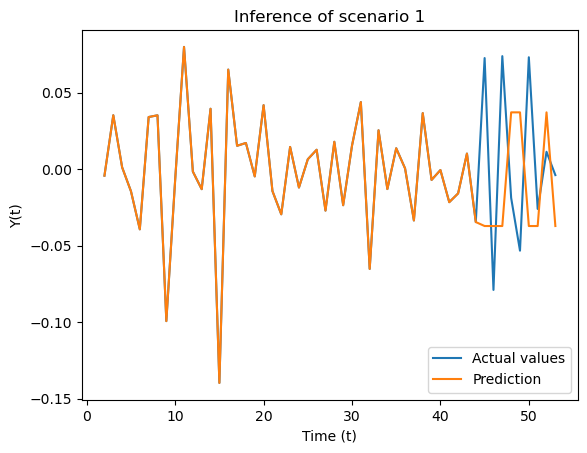

In [601]:
# get sequences for comparison
past_seq = df_stationary[(df_stationary.country == test_country)
                         & (df_stationary.year <= split_year)].energy_per_capita_stationary.to_list()
all_pred_seq = np.array(past_seq + pred_seq[1:]) 
all_actual_seq = np.array(past_seq + actual_seq)

nb_points = all_actual_seq.shape[0]
x_ = pd.unique(df_stationary.year)
print(len(x_), all_pred_seq.shape[0], len(past_seq))

# get curves on a sampe plot
plt.plot(np.arange(nb_points), all_actual_seq, label="Actual values")
plt.plot(np.arange(nb_points), all_pred_seq, label="Prediction")

plt.title("Inference of scenario 1")
plt.xlabel("Time (t)")
plt.ylabel("Y(t)")
plt.legend()
plt.show()

In [602]:
def reconstruct_signal(pred, past):
    """
    """
    true_pred = np.zeros_like(pred, dtype=np.float32)
    for i, val in np.ndenumerate(pred):

        x, y = past[-2:]

        new_y = np.exp(val - np.log(x) + 2*np.log(y))
        true_pred[i] = new_y
        
        past = np.hstack([past, new_y])

    past_array = np.array(past)
    return past_array

# Comparison with ARIMA model

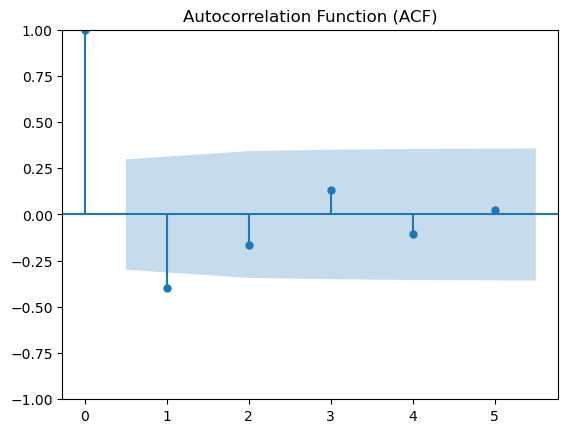

In [603]:
#
ts_stationary = df_stationary[df_stationary.country == test_country]
ts_stationary.set_index("year", inplace=True, drop=True)
ts_stationary = ts_stationary[["energy_per_capita_stationary"]]
ts_stationary.dropna(inplace=True)

plot_acf(ts_stationary[ts_stationary.index <= split_year], lags=5)
plt.title('Autocorrelation Function (ACF)')
plt.show()

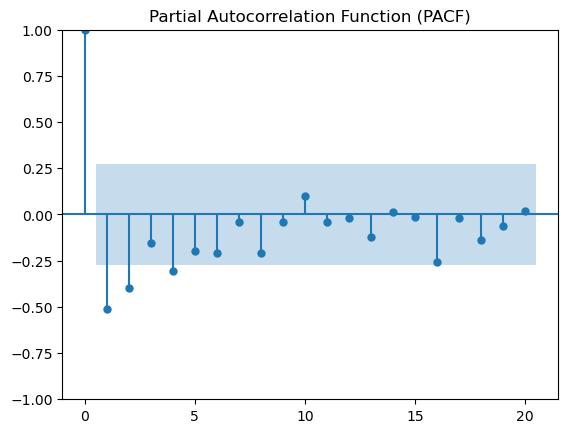

In [604]:
plot_pacf(ts_stationary[ts_stationary <= split_year], lags=20)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [605]:
# Replace p, d, q values with the parameters determined from ACF and PACF plots
p = 1  # AR order
d = 0  # differencing order (set to 0 for stationary data)
q = 2  # MA order
model = ARIMA(ts_stationary[ts_stationary <= split_year], order=(p, d, q))
results = model.fit()

# Summary of the ARIMA model
print(results.summary())

# Forecast future values
forecast_steps = length  # Number of steps ahead to forecast
forecast = results.forecast(steps=forecast_steps)

ts_stationary["pred_arima"] = list(ts_stationary[ts_stationary.index <= split_year].values) + list(forecast)

c:\Users\elkan\anaconda3\envs\time_series\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\elkan\anaconda3\envs\time_series\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\elkan\anaconda3\envs\time_series\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                     
Dep. Variable:     energy_per_capita_stationary   No. Observations:                   52
Model:                           ARIMA(1, 0, 2)   Log Likelihood                 109.895
Date:                          Wed, 10 Apr 2024   AIC                           -209.790
Time:                                  15:21:27   BIC                           -200.034
Sample:                                       0   HQIC                          -206.050
                                           - 52                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.000     -1.375      0.169      -0.001       0.000
ar.L1         -0.9137      0.136     -6.716      0.

c:\Users\elkan\anaconda3\envs\time_series\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\elkan\anaconda3\envs\time_series\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\elkan\anaconda3\envs\time_series\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [606]:
ts_stationary["pred_DBN"] = list(ts_stationary[ts_stationary.index <= split_year].energy_per_capita_stationary) + list(pred_seq[1:])

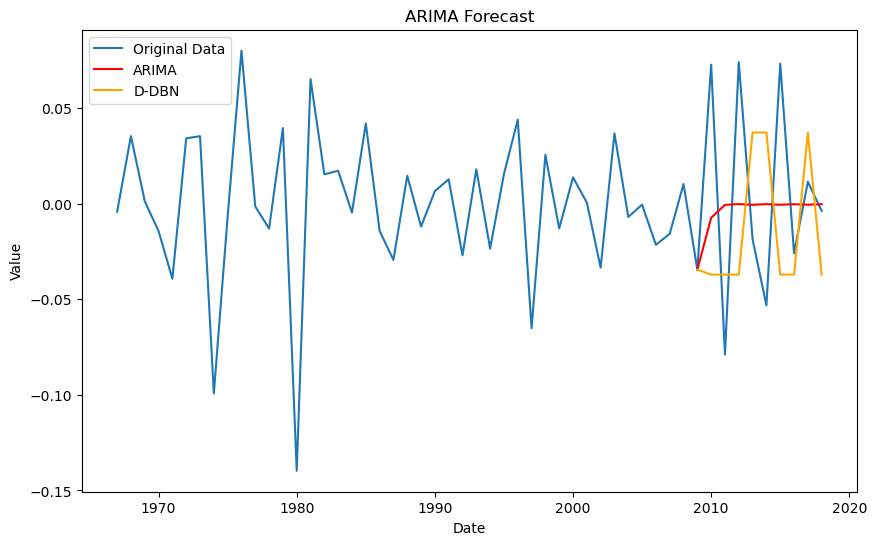

In [607]:
# Plot the original time series and the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(ts_stationary.energy_per_capita_stationary, label='Original Data')
plt.plot(ts_stationary[ts_stationary.index >= split_year].pred_arima, label='ARIMA', color='red')
plt.plot(ts_stationary[ts_stationary.index >= split_year].pred_DBN, label='D-DBN', color='orange')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

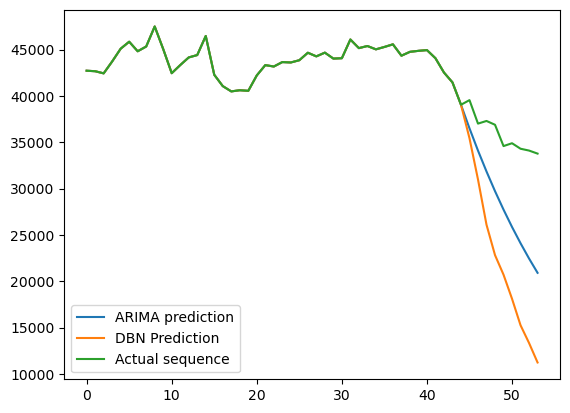

In [608]:
past_seq = list(data[(data.country == test_country)
                     & (data.year <= split_year)].energy_per_capita)
true_actual = data[(data.country == test_country)].energy_per_capita.to_numpy()

rec_actual = reconstruct_signal(actual_seq, past_seq)
true_pred_DBN = reconstruct_signal(pred_seq[1:], past_seq)
true_pred_ARIMA = reconstruct_signal(forecast, past_seq)

plt.plot(true_pred_ARIMA, label="ARIMA prediction")
plt.plot(true_pred_DBN, label="DBN Prediction")
plt.plot(true_actual, label="Actual sequence")

plt.legend()